#  Introduction
Below is a complete Python code for the Emotion Recognition project using OpenCV Haar cascades for face detection and DeepFace pre-trained model for emotion classification. This code will process a video file, detect faces, classify emotions, and annotate the video with recognized emotion.

## Imports:

- `cv2` for OpenCV functions.
- `DeepFace` from the DeepFace library for emotion classification.
- `VideoFileClip` and `AudioFileClip` from the moviepy library to handle video and audio processing.

## Face Detection:

- The `detect_faces` function uses a pre-trained Haar Cascade classifier to detect faces in a given frame. The frame is first converted to grayscale, and then faces are detected.

## Emotion Classification:

- The `classify_emotions` function uses DeepFace to analyze the detected face image and classify emotions. The function returns the emotion with the highest confidence.

## Frame Annotation:

- The `annotate_frame` function annotates each frame with rectangles around detected faces and labels them with the recognized emotions.

## Video Processing:

- The `process_video` function reads the input video, processes each frame to detect and classify emotions, annotates the frames, and writes them to an output video file. It also merges the original audio with the processed video.

## Execution:

- The script processes the input video and saves the annotated video to the specified output path. The processed video can then be downloaded using Google Colab's `files.download`.


In [1]:
!pip install opencv-python-headless deepface moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=15721d823b7bb4820215756b87c6fdd4846ac54ab679e86a42c1caae5cf4bf08
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [12]:
import cv2
from deepface import DeepFace
from moviepy.editor import VideoFileClip, vfx, AudioFileClip
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

In [3]:
def detect_faces(frame):
    """ Detect faces in the frame """
    # Load pre-trained Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    return faces

In [4]:
def classify_emotions(face_image):
    """ Classify emotions for the given face image """
    # Analyze face image using DeepFace
    result = DeepFace.analyze(face_image, actions=['emotion'], enforce_detection=False)

    if result:
        emotion = max(result[0]['emotion'], key=result[0]['emotion'].get)
    else:
        emotion = 'Unknown'

    return emotion

In [5]:
def process_video(video_path, output_path, slow_down_factor=1):
    cap = cv2.VideoCapture(video_path)

    # Check if the video capture was successful
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Get the frame rate (FPS)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Check if the FPS value is valid
    if fps == 0:
        print("Error: Unable to retrieve frame rate (FPS) of the video.")
        cap.release()
        return

    # Create VideoWriter object to write the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    temp_output_path = 'temp_output_video.mp4'
    out = cv2.VideoWriter(temp_output_path, fourcc, fps, (frame_width, frame_height))

    # Calculate the delay between frames to slow down label changes
    delay_ms = int(1000 / (fps * slow_down_factor))

    # Process each frame in the video
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of the video

        # Detect faces in the current frame
        faces = detect_faces(frame)

        # Annotate the frame with recognized emotions
        annotate_frame(frame, faces)

        # Write the frame to the output video
        out.write(frame)

        # Wait for a certain delay before processing the next frame
        cv2.waitKey(delay_ms)

    # Release VideoCapture and VideoWriter objects
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # Add original audio to the processed video
    video_clip = VideoFileClip(temp_output_path)
    original_clip = VideoFileClip(video_path)
    final_clip = video_clip.set_audio(original_clip.audio)
    final_clip.write_videofile(output_path, codec='libx264', audio_codec='aac')


In [6]:
def annotate_frame(frame, faces):
    """ Annotate the frame with recognized emotions """
    for (x, y, w, h) in faces:
        face_image = frame[y:y+h, x:x+w]  # Extract face region from frame
        emotion = classify_emotions(face_image)

        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Display the emotion label
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


In [14]:
def process_image(input_path, output_path):
    # Step 1: Read input image
    image = cv2.imread(input_path)
    if image is None:
        print(f"Error: Unable to read image at '{input_path}'")
        return

    # Step 2: Detect faces and annotate emotions
    faces = detect_faces(image)
    annotate_frame(image, faces)

    # Step 3: Write annotated image to output path
    cv2.imwrite(output_path, image)

    # Step 4: Combine input and output images horizontally
    input_image = cv2.imread(input_path)
    combined_image = cv2.hconcat([input_image, image])

    # Step 5: Save or display the combined image
    cv2.imwrite(output_path, combined_image)
    cv2_imshow(combined_image)  # Display combined image in Colab


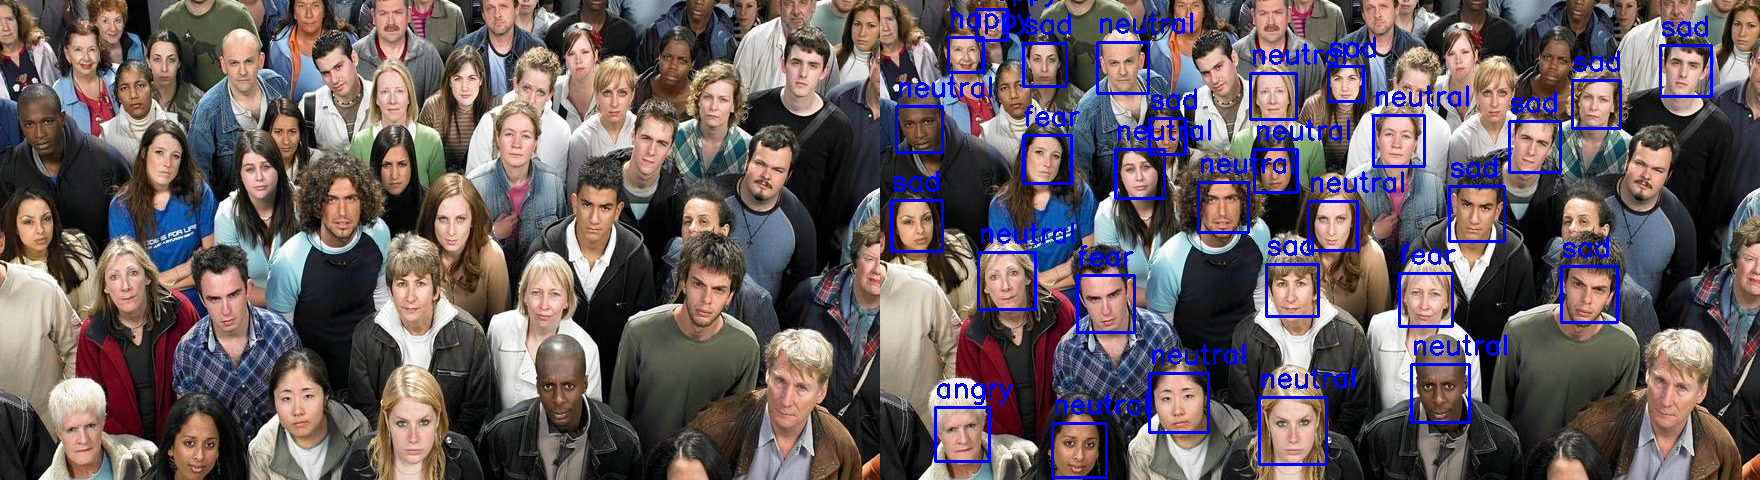

In [19]:
if __name__ == "__main__":
    input_path = '/content/many faces.jpeg'  # Update with your video or image path
    output_path = '/content/many faces od.jpeg' # Update with the desired output path

    if input_path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
        process_video(input_path, output_path)
    elif input_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        process_image(input_path, output_path)
    else:
        print("Unsupported file format. Please provide a video or image file.")


In [ ]:
import os
os.listdir('/content/')

['.config',
 '.ipynb_checkpoints',
 'baby_output_video.mp4',
 'Human_output_video.mp4',
 'WhatsApp Video 2024-06-10 at 3.43.23 PM.mp4',
 'طفل يضحك.mp4',
 'temp_output_video.mp4',
 'sample_data']

In [ ]:
from google.colab import files
files.download('/content/baby_output_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>